# 🧠 Clustering Countries by Livability and Infrastructure: Analysis Summary

## 1. 🔍 Data Exploration
The dataset includes 155 countries, with features such as:
- `average_monthly_cost_$`
- `average_yearly_temperature`
- `internet_speed_mbps`
- `safety_index`
- `Healthcare Index`

I began by examining **correlation** and **multicollinearity**:
- No pairwise correlation exceeded 0.8, and all **VIF values were below 2**, indicating no critical multicollinearity.
- However, **safety and healthcare** showed moderate correlation (~0.62), motivating further feature engineering to consolidate their shared signal.

---

## 2. ⚙️ Feature Engineering
To make the dataset more meaningful for clustering and account for how users perceive key features:

### ✅ Internet Speed Binning
Raw Mbps doesn’t reflect perceived value (e.g., the leap from 10 → 50 Mbps feels huge, but 150 → 300 Mbps often feels the same).

I discretized `internet_speed_mbps` into 5 bins:
- `Very Slow (<20 Mbps)`
- `Slow (20–49 Mbps)`
- `Good (50–99 Mbps)`
- `Fast (100–199 Mbps)`
- `Very Fast (200+ Mbps)`

### ✅ Safety + Healthcare Merging
To mitigate correlation and simplify interpretation, I averaged `safety_index` and `Healthcare Index` into a single feature:
```python
safety_healthcare_index = (safety + healthcare) / 2
```

### Final Engineered Feature Set:
- `average_monthly_cost_$`
- `average_yearly_temperature`
- `internet_speed_binned` (numeric value 0–4)
- `safety_healthcare_index`

---

## 3. 📐 PCA
To visualize country groupings, I ran **PCA with 3 components** on the **engineered and scaled features**:
- **Input matrix**: 4 features listed above
- **PCA was only used for visualization** — clustering was performed on the original feature space

---

## 4. 📏 Scaling
All features were scaled using `MinMaxScaler` to the [0, 1] range before clustering:
- Ensures fair weighting when computing distances for KMeans
- Especially important since KMeans uses **Euclidean distance**

---

## 5. 🔗 Clustering
I applied **KMeans clustering**, testing both `k=2` and `k=3`:

| k   | Silhouette Score | Interpretation                     |
|-----|------------------|-------------------------------------|
| 2   | 0.37             | ✅ Best separation, distinct groups |
| 3   | 0.31             | More granular but lower cohesion   |

### k=2 Clusters:
- **Cluster 0**: 🌴 *Affordable Warm Regions* — lower cost, slower internet, weaker infrastructure
- **Cluster 1**: 🏙️ *Cold & Connected Hubs* — higher cost, faster internet, strong safety/healthcare

### k=3 Clusters:
- **Cluster 0**: 🌍 *Modern Tropical Cities* — warm with decent infrastructure (e.g. Malaysia, Greece)
- **Cluster 1**: 🧊 *Cold & Connected* — elite hubs with great infrastructure (e.g. Germany, South Korea)
- **Cluster 2**: 💸 *Cheap but Basic* — budget locations with weak infrastructure (e.g. Pakistan, Nigeria)

---

## ✅ Final Notes
- All data and clusters were exported, including **readable labels for internet speed bins**.
- The final model provides **interpretable, actionable insights** for geographic segmentation based on livability and infrastructure quality.


# 🌍 Country Clustering by Livability and Infrastructure

This notebook performs unsupervised clustering on country-level data, including custom preprocessing, feature engineering, PCA, and clustering with KMeans.

## 🔍 1. Data Exploration & Multicollinearity Check

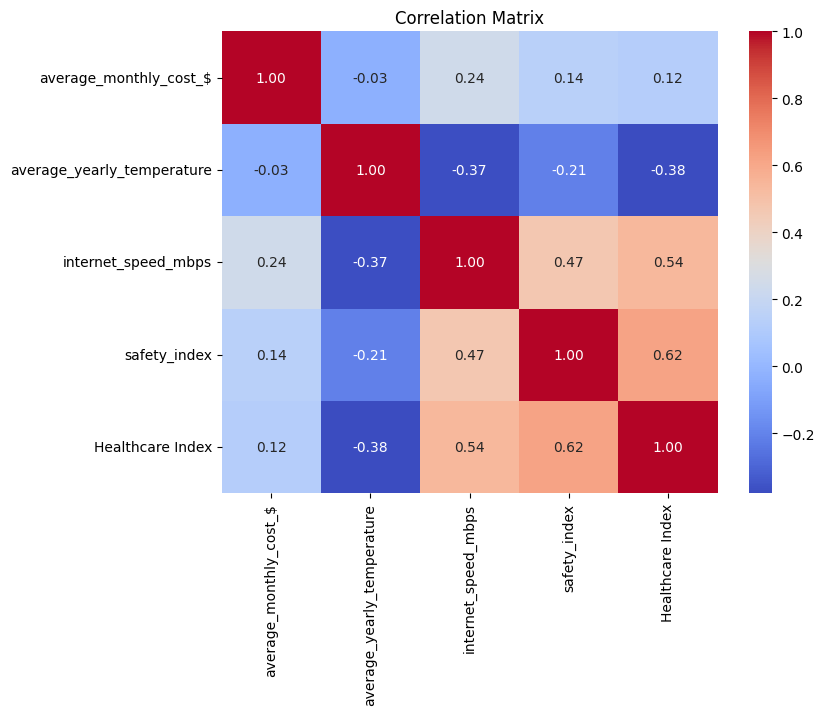

                      feature       VIF
0      average_monthly_cost_$  1.069620
1  average_yearly_temperature  1.238103
2         internet_speed_mbps  1.622508
3                safety_index  1.702368
4            Healthcare Index  1.970834


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv("../raw_data/merged_country_level/merged_dataset_with_knn.csv")

# Drop non-numeric column
df_numeric = df.drop(columns=["Unnamed: 0"])

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# VIF Calculation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)
vif_data = pd.DataFrame()
vif_data["feature"] = df_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print(vif_data)

## ⚙️ 2. Feature Engineering

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Start with a copy
df_preprocessed = df.drop(columns=["Unnamed: 0"]).copy()

# Discretize internet speed
def custom_bin_internet_speed(speed):
    if speed < 20:
        return 0
    elif speed < 50:
        return 1
    elif speed < 100:
        return 2
    elif speed < 200:
        return 3
    else:
        return 4

df_preprocessed["internet_speed_binned"] = df_preprocessed["internet_speed_mbps"].apply(custom_bin_internet_speed)
df_preprocessed.drop(columns=["internet_speed_mbps"], inplace=True)

# Combine safety + healthcare
df_preprocessed["safety_healthcare_index"] = (
    df_preprocessed["safety_index"] * 0.5 + df_preprocessed["Healthcare Index"] * 0.5
)
df_preprocessed.drop(columns=["safety_index", "Healthcare Index"], inplace=True)

# MinMax scale
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_preprocessed)

## 📐 3. PCA + Clustering (k=2 and k=3)

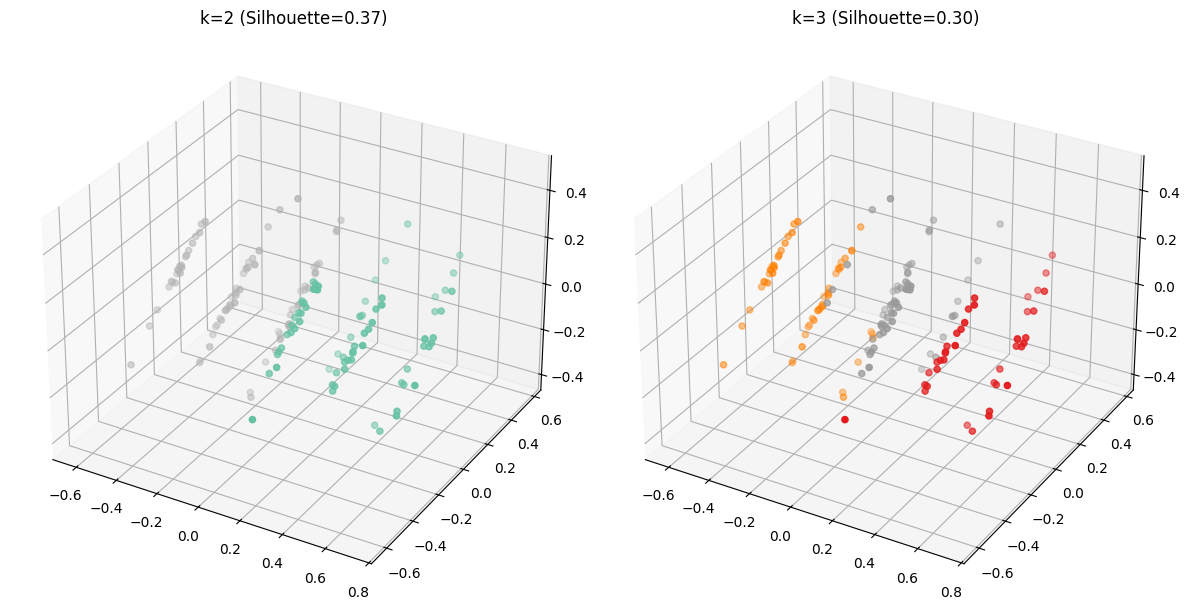

In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# KMeans
kmeans2 = KMeans(n_clusters=2, random_state=42).fit(X_scaled)
kmeans3 = KMeans(n_clusters=3, random_state=42).fit(X_scaled)

labels_k2 = kmeans2.labels_
labels_k3 = kmeans3.labels_

silhouette_k2 = silhouette_score(X_scaled, labels_k2)
silhouette_k3 = silhouette_score(X_scaled, labels_k3)

# Plotting
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=labels_k2, cmap='Set2')
ax1.set_title(f'k=2 (Silhouette={silhouette_k2:.2f})')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=labels_k3, cmap='Set1')
ax2.set_title(f'k=3 (Silhouette={silhouette_k3:.2f})')

plt.tight_layout()
plt.show()

## 🧠 4. Cluster Interpretation

In [5]:
df_interpret = df.copy()
df_interpret["cluster_k2"] = labels_k2
df_interpret["cluster_k3"] = labels_k3

summary_k2 = df_interpret.groupby("cluster_k2")[
    ["average_monthly_cost_$", "average_yearly_temperature", "internet_speed_mbps",
     "safety_index", "Healthcare Index"]
].mean().round(1)

summary_k3 = df_interpret.groupby("cluster_k3")[
    ["average_monthly_cost_$", "average_yearly_temperature", "internet_speed_mbps",
     "safety_index", "Healthcare Index"]
].mean().round(1)

print("Cluster Summary (k=2):\n", summary_k2)
print("\nCluster Summary (k=3):\n", summary_k3)

Cluster Summary (k=2):
             average_monthly_cost_$  average_yearly_temperature  \
cluster_k2                                                       
0                           1146.1                        16.8   
1                           1030.3                        25.4   

            internet_speed_mbps  safety_index  Healthcare Index  
cluster_k2                                                       
0                         159.3          61.1              66.7  
1                          44.1          46.9              51.2  

Cluster Summary (k=3):
             average_monthly_cost_$  average_yearly_temperature  \
cluster_k3                                                       
0                           1409.5                        14.8   
1                           1050.5                        25.6   
2                            901.8                        21.6   

            internet_speed_mbps  safety_index  Healthcare Index  
cluster_k3               